In [1]:
%cd ~/NetBeansProjects/ExpLosion/
from notebooks.common_imports import *

/Volumes/LocalDataHD/m/mm/mmb28/NetBeansProjects/ExpLosion


# State-of-the-art for word-level intrinsic eval
Bruni, Tran, Baroni (multimodal dist semantics):
 - ws: 0.7
 - men: 0.77
TODO Need to find more recent papers

RG: http://aclweb.org/aclwiki/index.php?title=RG-65_Test_Collection_(State_of_the_art)
$\rho=0.89$

# Test: instrinsic eval on noise-corrupted vectors

Add noise as usual, evaluate intrinsically.

### Coverage
Vectors trained on less data will have lower coverage of types, so they may not be able to provide and answer for all word pairs in the test sets. I handle this in two ways:
 - relaxed: OOV items are not looked at. This may provide an unfair advantage to vectors trained on less data, because we forgive their poor coverage
 - strict: OOV items score 0 correlation.
 
### PoS tags
Words in 3/4 datasets are provided without PoS tags (only MEN provides tags). In my work `cat/J`, `cat/N` and `cat/V` have different vectors, so before evaluation I need to map `cat` to one of these two versions. I use the first PoS tag that is found, in the order `JNV`. I could have ignored words in the test set that may map to multiple PoS tags.
 
 
### Questions
 - Do people use the strict version?
 - What do I do with multiple possible POS tags per word for `ws353` data?

# Running experiment
Run `thesisgenerator/scripts/intrinsic_eval_words.py` first and make sure results are in the right place.

/Volumes/LocalDataHD/m/mm/mmb28/NetBeansProjects/seaborn/seaborn/categorical.py:2653: UserWarning: The `x_order` parameter has been renamed `order`
  UserWarning)

  UserWarning)



ValueError: num must be 0 <= num <= 2, not 3

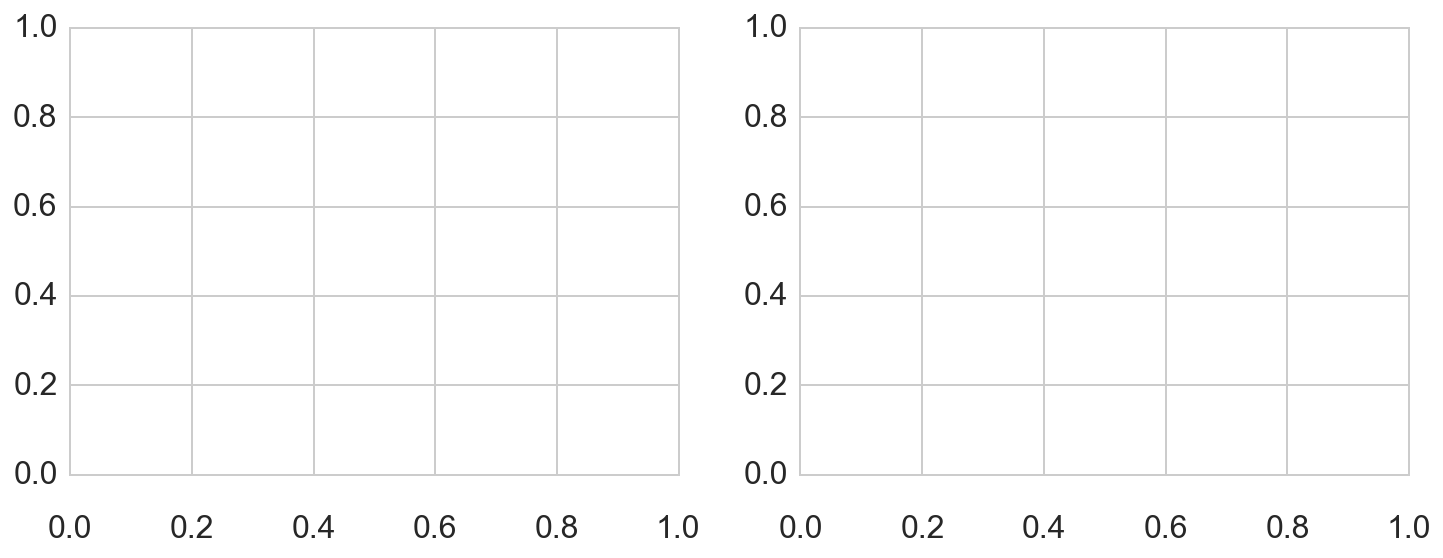

In [20]:
noise_df = pd.read_csv('../thesisgenerator/intrinsic_noise_word_level.csv')
%autoreload
with sns.axes_style('whitegrid'):
    g = sns.factorplot(x='noise', hue='vect', col='test', y='corr', col_wrap=2,
                       data=noise_df[noise_df.kind == 'strict'], kind='point', 
                       x_order=sorted(noise_df.noise.unique()), aspect=1.5,
                      col_order = ['men', 'ws353', 'rg', 'mc']);
g.set_ylabels('Spearman $\\rho$')
sns.despine(left=True, bottom=True)
for ax in g.axes.flat:
    sparsify_axis_labels(ax)
    ax.axhline(0, c='k')
    
plt.savefig('plot-intrinsic-noise.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

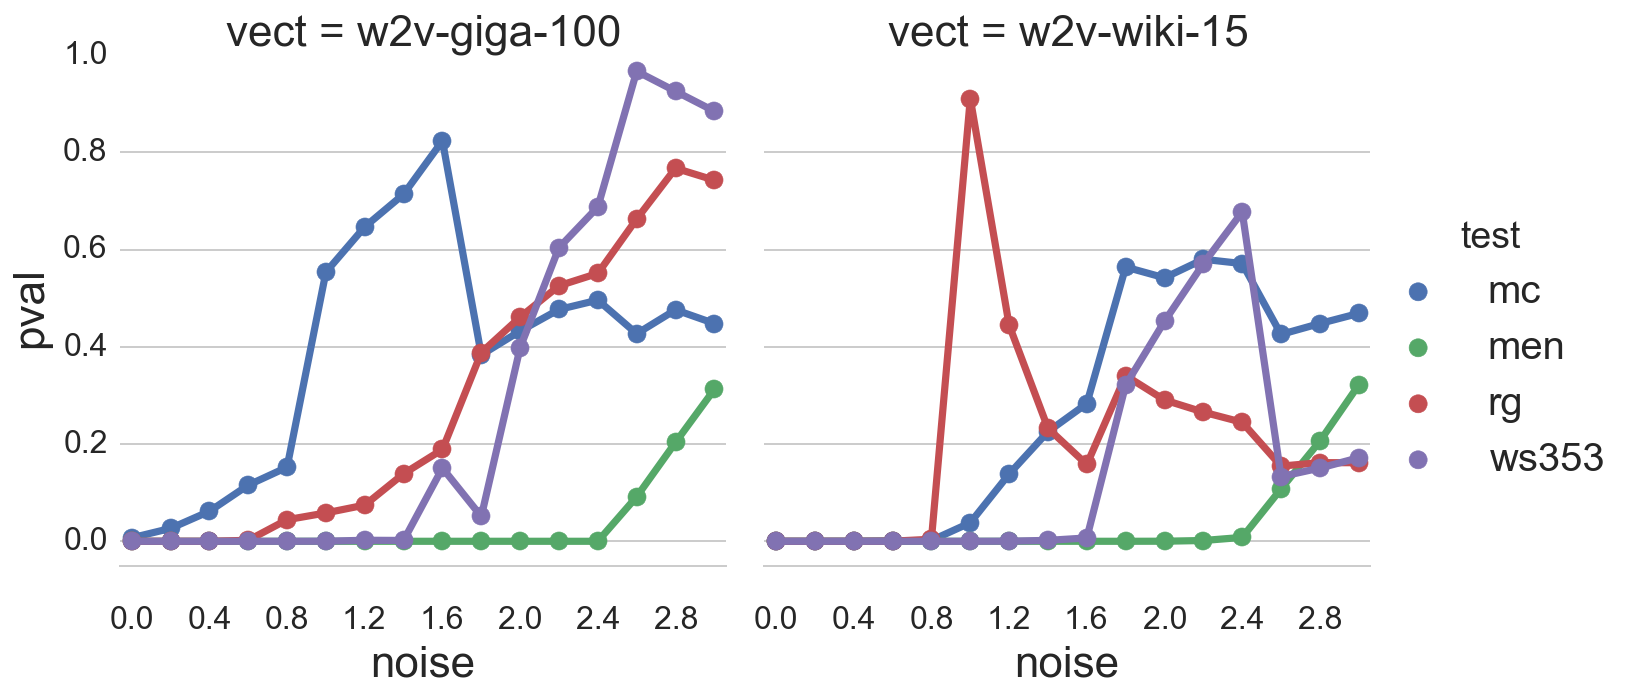

In [31]:
with sns.axes_style('whitegrid'):
    g = sns.factorplot(x='noise', col='vect', hue='test', y='pval',
                   data=noise_df[noise_df.kind == 'strict'], 
                   kind='point', 
                   x_order=sorted(noise_df.noise.unique()));
sns.despine(left=True)
for ax in g.axes.flat:
    sparsify_axis_labels(ax)
    ax.set_ylim(-0.05, 1)
plt.savefig('plot-intrinsic-pvals.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

 
# Observations
 - Measured vector quality decreases nicely for WS353/MEN, oscilates for MC/RG.
 - P-value of correlation for smallers datasets explodes early, i.e. chance of such a strong correlation being observed by chance. Test has low power

# Test: Learning curve

Evaluate vectors intrinsically as more unlabelled training data is added 

In [17]:
# learning curve
query_dict = {'expansions__vectors__rep': 0, 
                'expansions__k':3,
                'labelled':'amazon_grouped-tagged',
                'expansions__use_similarity': 0, 
                'expansions__neighbour_strategy':'linear',
                'expansions__vectors__dimensionality': 100, 
                'document_features_ev': 'AN+NN', 
                'document_features_tr': 'J+N+AN+NN', 
                'expansions__allow_overlap': False,
                'expansions__entries_of': None,
                'expansions__vectors__algorithm': 'word2vec',
                'expansions__vectors__composer': 'Add',
                'expansions__vectors__unlabelled': 'wiki',
                'expansions__decode_handler': 'SignifiedOnlyFeatureHandler',
                'expansions__noise': 0}
experiments = Experiment.objects.filter(**query_dict).order_by('expansions__vectors__unlabelled_percentage')
print([e.id for e in experiments])
curve_data = []
import os
for e in experiments:
    print("(%d, '%s')," %(e.expansions.vectors.unlabelled_percentage, os.path.basename(e.expansions.vectors.path)))

[113, 114, 87, 115, 116, 117, 118, 119, 120, 121, 122, 34]
(1, 'AN_NN_word2vec-wiki_1percent-rep0_Add.events.filtered.strings')
(10, 'AN_NN_word2vec-wiki_10percent-rep0_Add.events.filtered.strings')
(15, 'AN_NN_word2vec-wiki_15percent-rep0_Add.events.filtered.strings')
(20, 'AN_NN_word2vec-wiki_20percent-rep0_Add.events.filtered.strings')
(30, 'AN_NN_word2vec-wiki_30percent-rep0_Add.events.filtered.strings')
(40, 'AN_NN_word2vec-wiki_40percent-rep0_Add.events.filtered.strings')
(50, 'AN_NN_word2vec-wiki_50percent-rep0_Add.events.filtered.strings')
(60, 'AN_NN_word2vec-wiki_60percent-rep0_Add.events.filtered.strings')
(70, 'AN_NN_word2vec-wiki_70percent-rep0_Add.events.filtered.strings')
(80, 'AN_NN_word2vec-wiki_80percent-rep0_Add.events.filtered.strings')
(90, 'AN_NN_word2vec-wiki_90percent-rep0_Add.events.filtered.strings')
(100, 'AN_NN_word2vec-wiki_100percent-rep0_Add.events.filtered.strings')


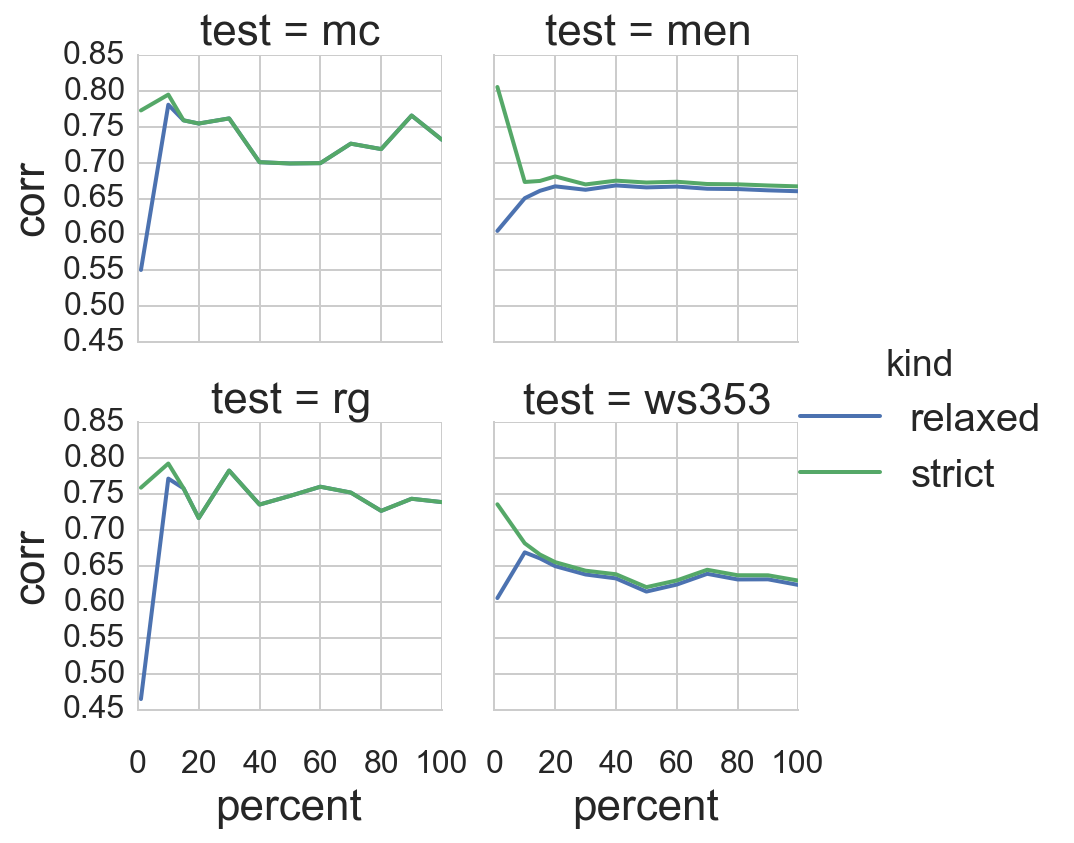

In [28]:
with sns.axes_style('whitegrid'):
    curve_df = pd.read_csv('../thesisgenerator/intrinsic_learning_curve_word_level.csv')
    g = sns.FacetGrid(curve_df, col='test', col_wrap=2, hue='kind');
    g.map(plt.plot, 'percent', 'corr')
    g.add_legend()

plt.savefig('plot-intrinsic-learning-curve.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# Observation

None of the intrinsic tests but can tell between `wiki-15` and `wiki-100`, regardless of dataset size. 

I thought this may be because I was using the relaxed score, but the difference between relaxed and strict is generally small. Such a difference only arises when a model's coverage of the test words is poor, i.e. when unlabelled data is very limited. This isn't a real issue (see below)

# Coverage
Almost perfect after 10% of wikipedia

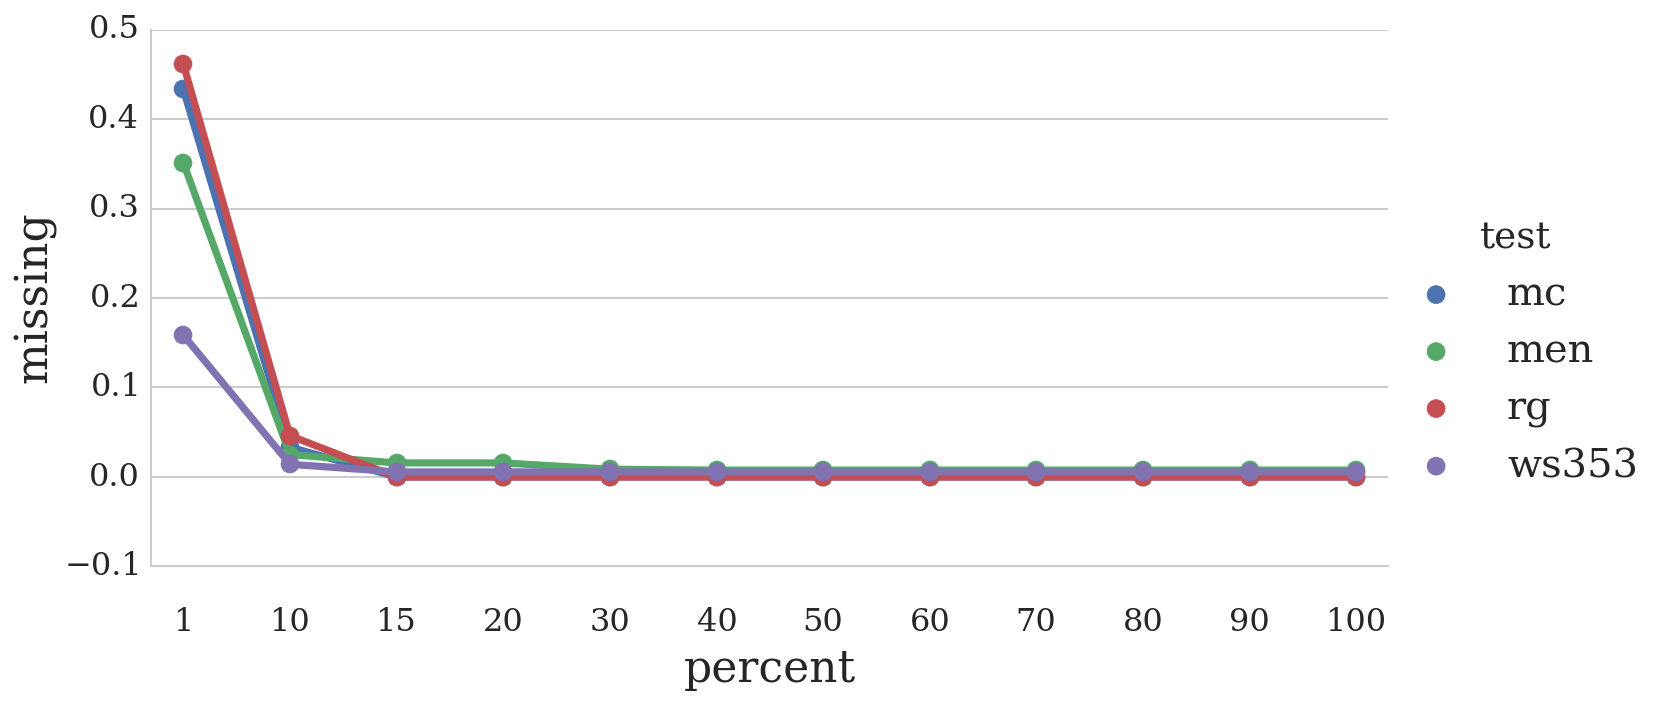

In [10]:
g = sns.factorplot(y='missing', x='percent', hue='test', data=curve_df, aspect=2);

In [18]:
np.arange(0, 3.1, .2).shape

(16,)